In [ ]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from general_utils.utils import get_lagplot
from neural_utils.utils import load_monkey_data, load_stimuli_models, random_trials_per_rep, min_max_normalization, extract_fixation_responses_sing_trial, extract_fixation_responses_sing_ 

In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold, GroupKFold

In [149]:
monkey_name = "red"
month = 'aug'
day = 25
resolution_Hz = 100
npx = False
imec_n = 0
normalization = "min_max"
model_name = "dgIIE"
day = str(day)
neural_data, gaze_data = load_monkey_data(paths, monkey_name, day, month, resolution_Hz, npx=npx, imec_n=imec_n)
# normalizes them 
if normalization == "min_max":
    n_norm = min_max_normalization(neural_data)
# ADD zscore? robust?
elif normalization == None:
    n_norm = delete_empty_keys(neural_data)

# loads and upsamples the model 
all_models = load_stimuli_models(paths, model_name, n_norm.keys(), resolution_Hz)

# extract_fixation_responses(n_norm, gaze_data, all_models, n_timepts_bef, n_timepts_aft, foreperiod_len_timepts=30)

In [150]:
neural_data_fix, gaze_data_fix, model_data_fix = extract_fixation_responses_sing_trial(n_norm, gaze_data, all_models, list(n_norm.keys())[0], 0, 10, 40, stack=1)

In [44]:
l = []
for i in range(3):
    a = np.random.randint(10, size=(10,20))
    print(a.shape)
    l.append(a)
np.concatenate(l).shape

(10, 20)
(10, 20)
(10, 20)


(30, 20)

In [80]:
neural_data_fix.shape

(383, 50, 24)

In [ ]:
# the other way would be to do all the timepoints at the same time and then play with the lag
# but how to treat different trials? 
lr_list = []
ridge_list = []
lasso_list = []
en_list = []
max_lag = 20

half_trials = round(neural_data_fix.shape[2]/2)
for L in range(-max_lag, max_lag):
    x_shifted_tot = []
    y_shifted_tot = []
    x_t_shifted_tot = []
    y_t_shifted_tot = [] 
    for i in range(half_trials):
        X = neural_data_fix[0:20,:,i].T
        y = neural_data_fix[20:40,:,i].T
        X_test = neural_data_fix[0:20,:,half_trials].T
        y_test = neural_data_fix[20:40,:,i+half_trials].T
        
        if L > 0:  # if positive lag
            x_shifted = X[:-L,:] # mod is shifted towards the right (so present neural is being compared with past model)
            y_shifted = y[L:,:]
            x_t_shifted = X_test[:-L,:]
            y_t_shifted = y_test[L:,:]
        elif L == 0:  # Handle L=0 case explicitly
            x_shifted = X
            y_shifted = y
            x_t_shifted = X_test
            y_t_shifted = y_test
        else:  # L < 0
            x_shifted = X[-L:,:] # mod is shifted towards the left (so present neural is being compared with future model)
            y_shifted = y[:L,:]
            x_t_shifted = X_test[-L:,:]
            y_t_shifted = y_test[:L,:]
        x_shifted_tot.append(x_shifted)
        y_shifted_tot.append(y_shifted)
        x_t_shifted_tot.append(x_t_shifted)
        y_t_shifted_tot.append(y_t_shifted)
       
    x_shifted_tot = np.concatenate(x_shifted_tot, axis=0)
    y_shifted_tot = np.concatenate(y_shifted_tot, axis=0)
    x_t_shifted_tot = np.concatenate(x_t_shifted_tot, axis=0)
    y_t_shifted_tot = np.concatenate(y_t_shifted_tot, axis=0)
    lr = LinearRegression().fit(x_shifted_tot, y_shifted_tot)
    ridge = Ridge(alpha=1.0).fit(x_shifted_tot, y_shifted_tot)
    lasso = Lasso(alpha=1.0).fit(x_shifted_tot, y_shifted_tot)
    en = ElasticNet(alpha=1.0).fit(x_shifted_tot, y_shifted_tot)
    lr_list.append(lr.score(x_t_shifted_tot, y_t_shifted_tot))
    ridge_list.append(ridge.score(x_t_shifted_tot, y_t_shifted_tot))
    lasso_list.append(lasso.score(x_t_shifted_tot, y_t_shifted_tot))
    en_list.append(en.score(x_t_shifted_tot, y_t_shifted_tot))


ValueError: Found array with 0 feature(s) (shape=(1500, 0)) while a minimum of 1 is required by LinearRegression.

In [123]:
from neural_utils.utils import face_fixations
tot_face_fixation, tot_occluded_face_fixation, tot_non_face_fixation, tot_rep_face_fixation = face_fixations(paths, monkey_name, range(19, 25), month, npx, imec_n, resolution_Hz, 5, 20, 30, "human_face_detection", normalization)

15:46:07 - computed day 19 of monkey venus
15:46:07 - computed day 20 of monkey venus
15:46:08 - computed day 21 of monkey venus
15:46:08 - computed day 22 of monkey venus
15:46:08 - computed day 23 of monkey venus
15:46:08 - computed day 24 of monkey venus


In [116]:
tot_face_fixation.shape

(383, 50, 177)

In [130]:
neural_data_fix = np.random.randn(20, 50, 100)
model_data_fix = 20*neural_data_fix +10

In [134]:
print(neural_data_fix.shape)
print(model_data_fix.shape)

(20, 50, 100)
(20, 50, 100)


In [ ]:
from sklearn.linear_model import RidgeCV, MultiTaskLassoCV, MultiTaskElasticNetCV
#neural_data_fix, gaze_data_fix, model_data_fix = extract_fixation_responses_sing_stim(n_norm, gaze_data, all_models, list(n_norm.keys())[0], 10, 40, stack=1)
# the other way would be to do all the timepoints at the same time and then play with the lag
# but how to treat different trials? 

#neural_data_fix = tot_face_fixation
lr_list = []
ridge_list = []
lasso_list = []
en_list = []
max_lag = 10

half_trials = int(neural_data_fix.shape[2]/2)
for L in range(-max_lag, max_lag):
    x_shifted_tot = []
    y_shifted_tot = []
    x_t_shifted_tot = []
    y_t_shifted_tot = [] 
    for i in range(half_trials):
        X = neural_data_fix[0:20,:,i].T
        y = neural_data_fix[0:20,:,i].T
        X_test = neural_data_fix[0:20,:,i+half_trials].T
        y_test = neural_data_fix[0:20,:,i+half_trials].T
        
        if L > 0:  # if positive lag
            x_shifted = X[:-L,:] # mod is shifted towards the right (so present neural is being compared with past model)
            y_shifted = y[L:,:]
            x_t_shifted = X_test[:-L,:]
            y_t_shifted = y_test[L:,:]
        elif L == 0:  # Handle L=0 case explicitly
            x_shifted = X
            y_shifted = y
            x_t_shifted = X_test
            y_t_shifted = y_test
        else:  # L < 0
            x_shifted = X[-L:,:] # mod is shifted towards the left (so present neural is being compared with future model)
            y_shifted = y[:L,:]
            x_t_shifted = X_test[-L:,:]
            y_t_shifted = y_test[:L,:]
        x_shifted_tot.append(x_shifted)
        y_shifted_tot.append(y_shifted)
        x_t_shifted_tot.append(x_t_shifted)
        y_t_shifted_tot.append(y_t_shifted)
       
    x_shifted_tot = np.concatenate(x_shifted_tot, axis=0)
    y_shifted_tot = np.concatenate(y_shifted_tot, axis=0)
    x_t_shifted_tot = np.concatenate(x_t_shifted_tot, axis=0)
    y_t_shifted_tot = np.concatenate(y_t_shifted_tot, axis=0)
    lr = LinearRegression().fit(x_shifted_tot, y_shifted_tot)
    ridge = RidgeCV().fit(x_shifted_tot, y_shifted_tot)
    lasso = MultiTaskLassoCV().fit(x_shifted_tot, y_shifted_tot)
    en = MultiTaskElasticNetCV().fit(x_shifted_tot, y_shifted_tot)
    lr_list.append(lr.score(x_t_shifted_tot, y_t_shifted_tot))
    ridge_list.append(ridge.score(x_t_shifted_tot, y_t_shifted_tot))
    lasso_list.append(lasso.score(x_t_shifted_tot, y_t_shifted_tot))
    en_list.append(en.score(x_t_shifted_tot, y_t_shifted_tot))


(492, 20)


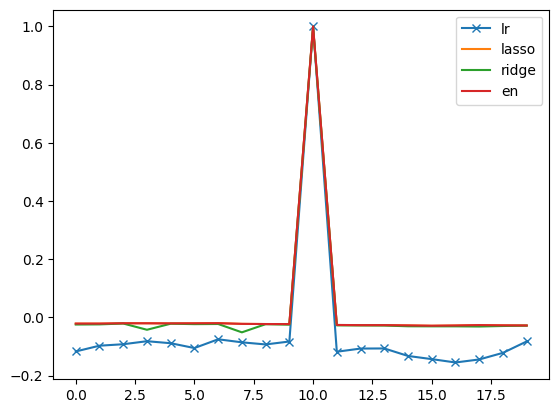

In [173]:
plt.plot(lr_list, marker="x")
plt.plot(lasso_list)
plt.plot(ridge_list)
plt.plot(en_list)
plt.legend([ "lr", "lasso","ridge", "en"])
plt.show()

In [ ]:
# the other way would be to do all the timepoints at the same time and then play with the lag
# but how to treat different trials? 
lr_mat = np.empty((neural_data_fix.shape[1], neural_data_fix.shape[1]))
ridge_mat = np.empty((neural_data_fix.shape[1], neural_data_fix.shape[1]))
lasso_mat = np.empty((neural_data_fix.shape[1], neural_data_fix.shape[1]))
en_mat = np.empty((neural_data_fix.shape[1], neural_data_fix.shape[1]))
for t_neu in range(neural_data_fix.shape[1]):
    y = neural_data_fix[:,t_neu,:].T
    for t_mod in range(neural_data_fix.shape[1]):
        X = gaze_data_fix[:,t_neu,:].T
        lr = LinearRegression().fit(X, y)
        ridge = Ridge(alpha=1.0).fit(X, y)
        lasso = Lasso(alpha=1.0).fit(X, y)
        en = ElasticNet(alpha=1.0).fit(X, y)
        lr_mat[t_neu, t_mod] = lr.score(X, y)
        ridge_mat[t_neu, t_mod] = ridge.score(X, y)
        lasso_mat[t_neu, t_mod] = lasso.score(X, y)
        en_mat[t_neu, t_mod] = en.score(X, y)

/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to inc

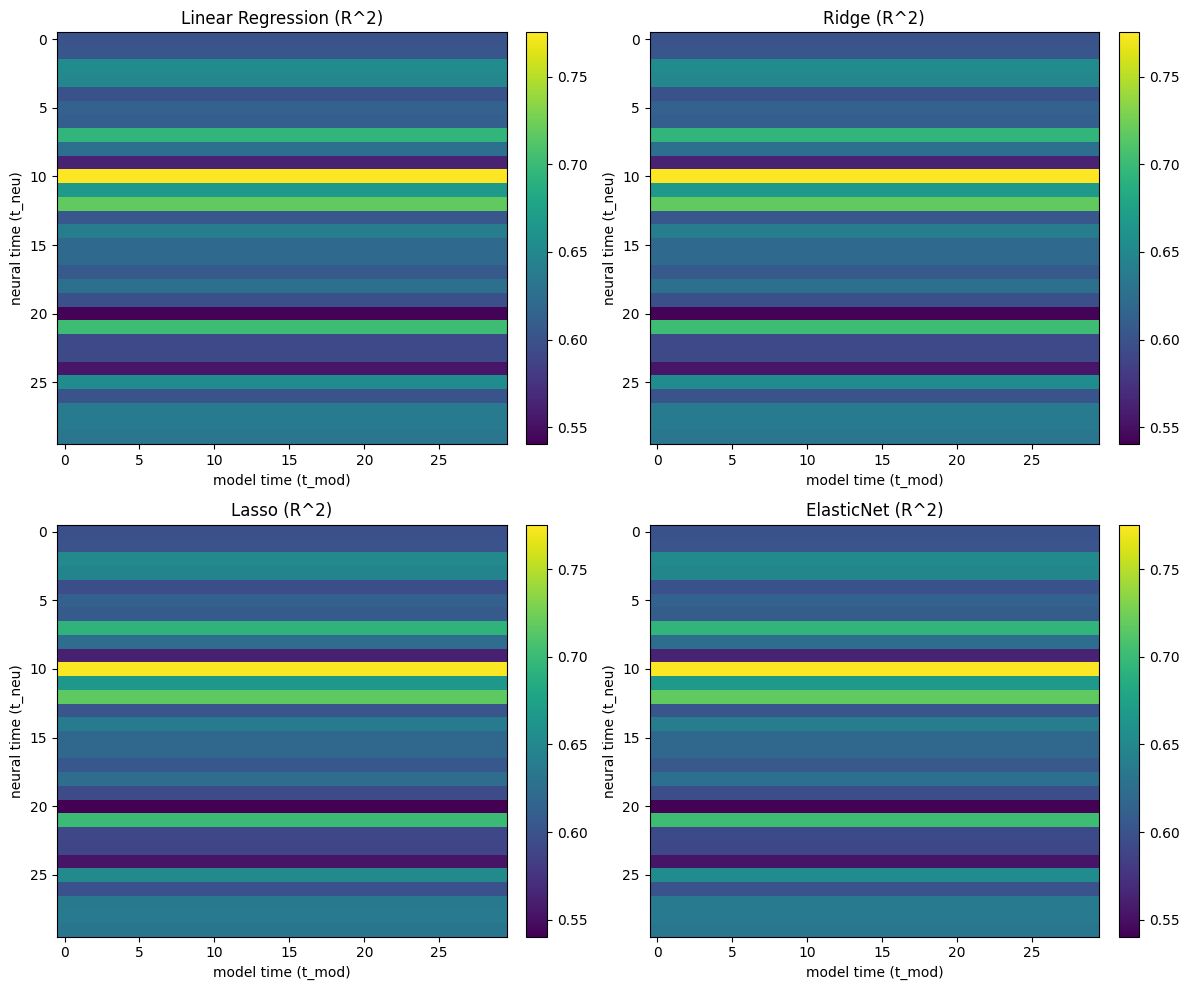

In [19]:
# plot 4 matrices in a 2x2 grid, sharing color scale
mats = [lr_mat, ridge_mat, lasso_mat, en_mat]
titles = ['Linear Regression (R^2)', 'Ridge (R^2)', 'Lasso (R^2)', 'ElasticNet (R^2)']

vmin = min(np.nanmin(m) for m in mats)
vmax = max(np.nanmax(m) for m in mats)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
for ax, mat, title in zip(axes.ravel(), mats, titles):
    im = ax.imshow(mat, aspect='auto', cmap='viridis', vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.set_xlabel('model time (t_mod)')
    ax.set_ylabel('neural time (t_neu)')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

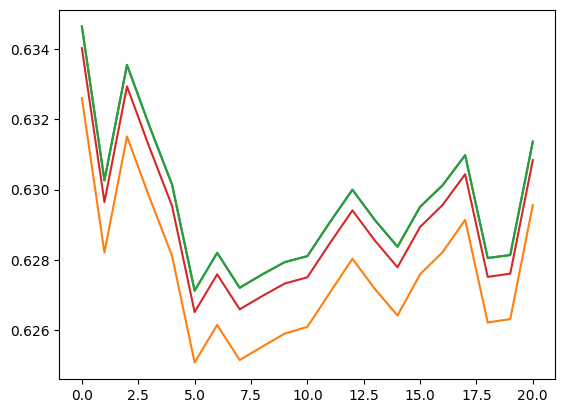

In [20]:
plt.plot(get_lagplot(lr_mat, max_lag=10))
plt.plot(get_lagplot(lasso_mat, max_lag=10))
plt.plot(get_lagplot(ridge_mat, max_lag=10))
plt.plot(get_lagplot(en_mat, max_lag=10))